In [6]:
# Description: Training the model by Xiomara Salazar
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
df = pd.read_csv('test_manual_labeld_twitter.csv')
df.dropna(inplace=True)
df.head()

,Unnamed: 0,id_str,user.id_str,text,sentiment,date,keyword,misinfo,context,source
0,0,1622367295052849153,947655331,@ZeekArkham @JCAndersonNYC Imagine all law enf...,0.3182,2023-02-05 22:51:19+00:00,purge+law,0,no context/not related to SAFE-T Act,twitter
1,1,1622329248827727872,1572624794226688000,We tried a law to purge us of this demon dubni...,0.0000,2023-02-05 20:20:08+00:00,purge+law,0,no context/not related to SAFE-T Act,twitter
3,3,1622280256248741893,1502547939658448897,@patriottakes Why is anyone surprised?\nVow re...,0.5106,2023-02-05 17:05:28+00:00,purge+law,0,no context/not related to SAFE-T Act,twitter
4,4,1622251716715622403,320685195,Yeah no suggesting you’re going to kill Americ...,-0.8519,2023-02-05 15:12:03+00:00,purge+law,0,no context/not related to SAFE-T Act,twitter
5,5,1621932335615692801,1530347136667222016,@Flash_news_ua When did EU Neo-Colonialists ev...,-0.5423,2023-02-04 18:02:57+00:00,purge+law,0,no context/not related to SAFE-T Act,twitter


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.misinfo
features.shape

(289, 116)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np

category_to_id = {'Misinfo': 1, 'Not misinfo': 0}
N = 2
for classification, class_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == class_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(classification))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Misinfo':
  . Most correlated unigrams:
. gloves
. webinar
  . Most correlated bigrams:
. fairness act
. end social
# 'Not misinfo':
  . Most correlated unigrams:
. gloves
. webinar
  . Most correlated bigrams:
. fairness act
. end social


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['misinfo'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

**Classifier created and predicts test strings**

In [11]:
test_1 = "The purge law is coming to Chicago"
test_2 = "Illinois’ SAFE-T Act Is Actually Unsafe. This law will be horrible. It will let the crazies kill us"

In [12]:
print(clf.predict(count_vect.transform([test_1])))

['0']


In [13]:
print(clf.predict(count_vect.transform([test_2])))

['0']


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score



models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


*How other models perform?*

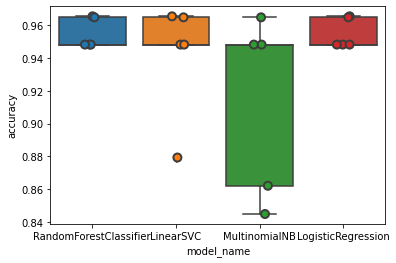

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.941258
LogisticRegression        0.955051
MultinomialNB             0.913672
RandomForestClassifier    0.955051
Name: accuracy, dtype: float64

In [18]:
import pickle
pickle.dump(clf, open('model.pkl', 'wb'))




In [19]:
import sklearn
sklearn.__version__

'1.2.1'